## Import modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import datetime
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import  matplotlib.dates as mdates
from tqdm import tqdm

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
import mlfinlab as ml
from mlfinlab.data_structures import imbalance_data_structures as imbar, run_data_structures as rbar, standard_data_structures as bar

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml.multiprocessing import mp_pandas_obj
from finance_ml import sampling, features

## Plot

In [56]:
def plot_fd(df, fd, desc='fracdiff'):
    fig, ax1 = plt.subplots(figsize=(18,10))
    plt.title('FracDiff over the prices')
    ax1.plot(fd.index, df.loc[fd.index,'close'], label = 'Raw prices', color = 'blue')
    
    ax2 = ax1.twinx()
    ax2.plot(fd.index, fd, color = 'red', label = desc)
    fig.figsizes = (18,10)
    plt.legend()
    plt.show()

## Load data

In [3]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [107]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)
df['close'] = df['PRICE']

In [6]:
close = df.loc['2018-01-03', 'close']

In [7]:
close.shape

(30693,)

In [16]:
close.columns = ['close']

In [19]:
close = pd.DataFrame(close, columns=['close'])

In [20]:
close.head()

,close
TIMESTAMP,
2018-01-03 09:00:21.481,20655
2018-01-03 09:00:21.614,20655
2018-01-03 09:00:21.754,20660
2018-01-03 09:00:22.141,20660
2018-01-03 09:00:22.251,20660


## Standard Fracdiff (Expanding window)

In [11]:
def getWeights(d, size): 
    # thres>0 drops insignificant weights
    w = [1.]
    for k in range(1,size):
        w_ = -w[-1] / k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w

In [59]:
def fracDiff(series, d, thres=.01):
    """
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    """
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):
                continue # exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

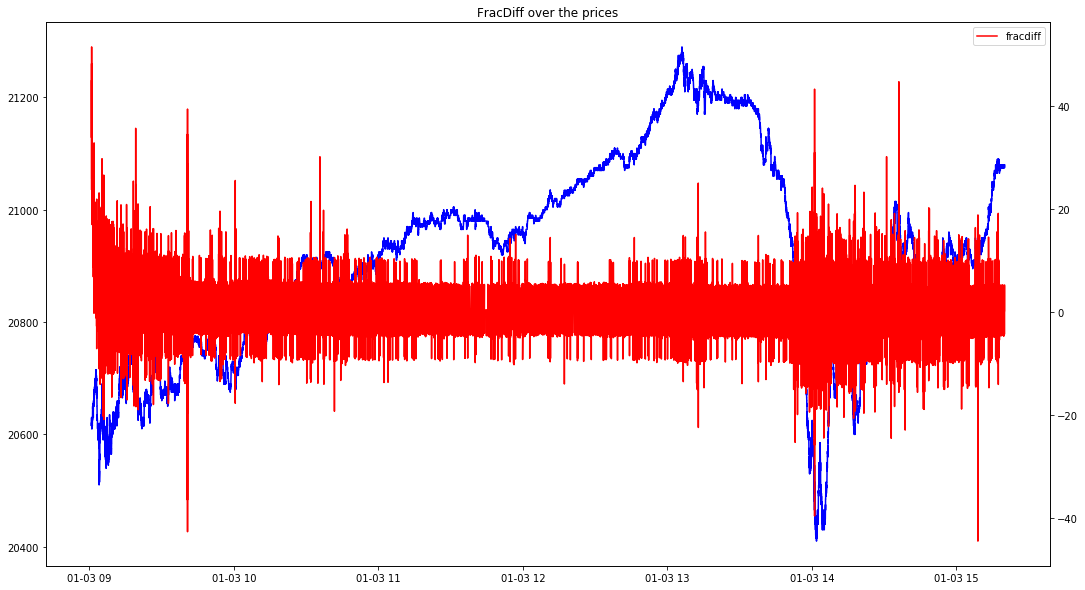

In [88]:
std_df = fracDiff(close, 0.9, thres=1e-3)
plot_fd(close, std_df)

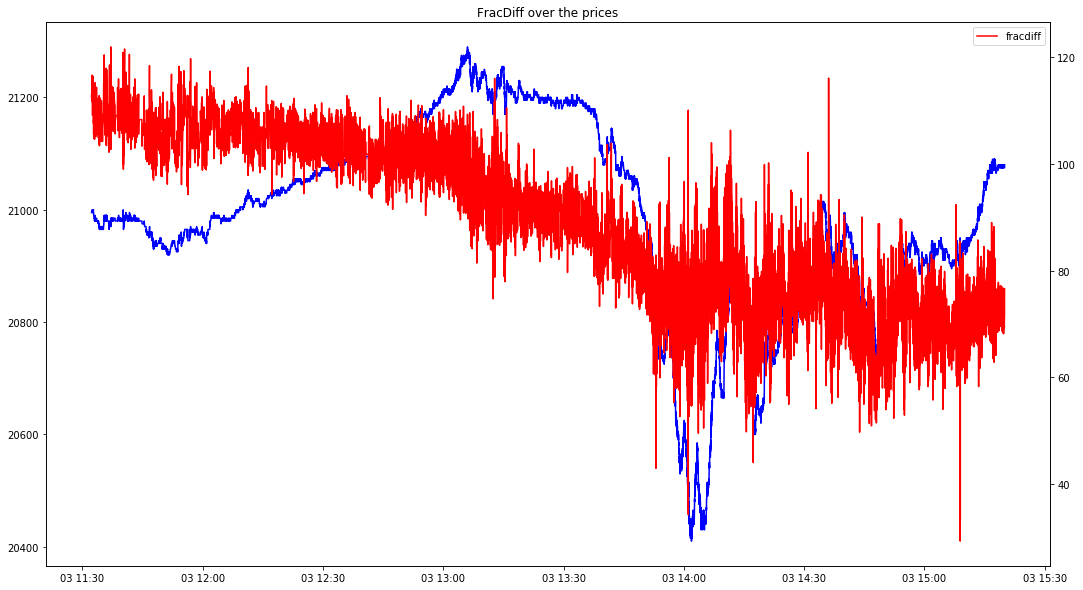

In [87]:
std_df = fracDiff(close, 0.5, thres=1e-3)
plot_fd(close, std_df)

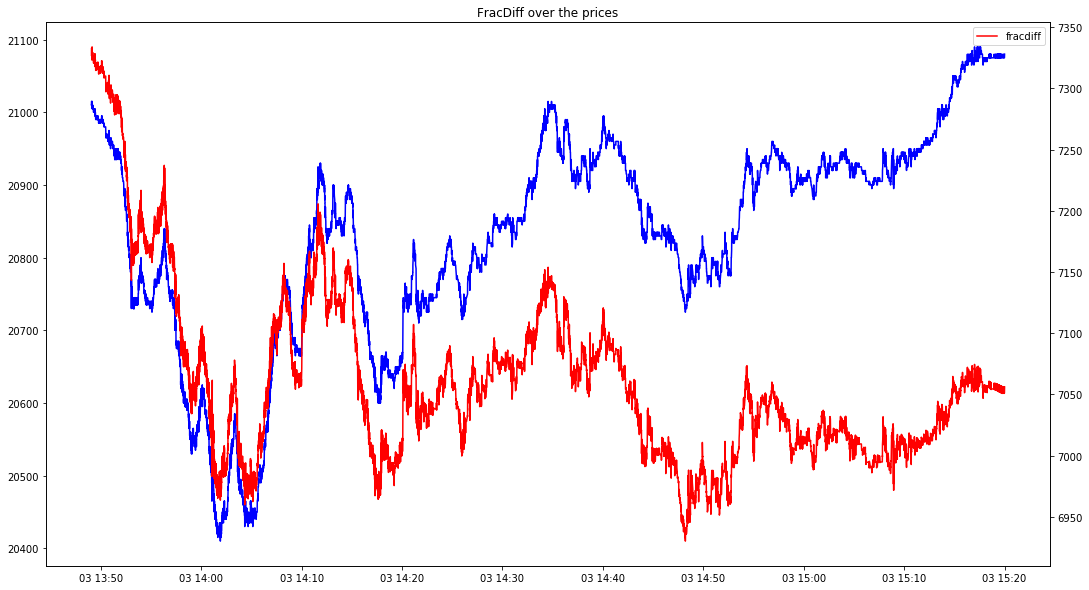

In [86]:
std_df = fracDiff(close, 0.1, thres=1e-2)
plot_fd(close, std_df)

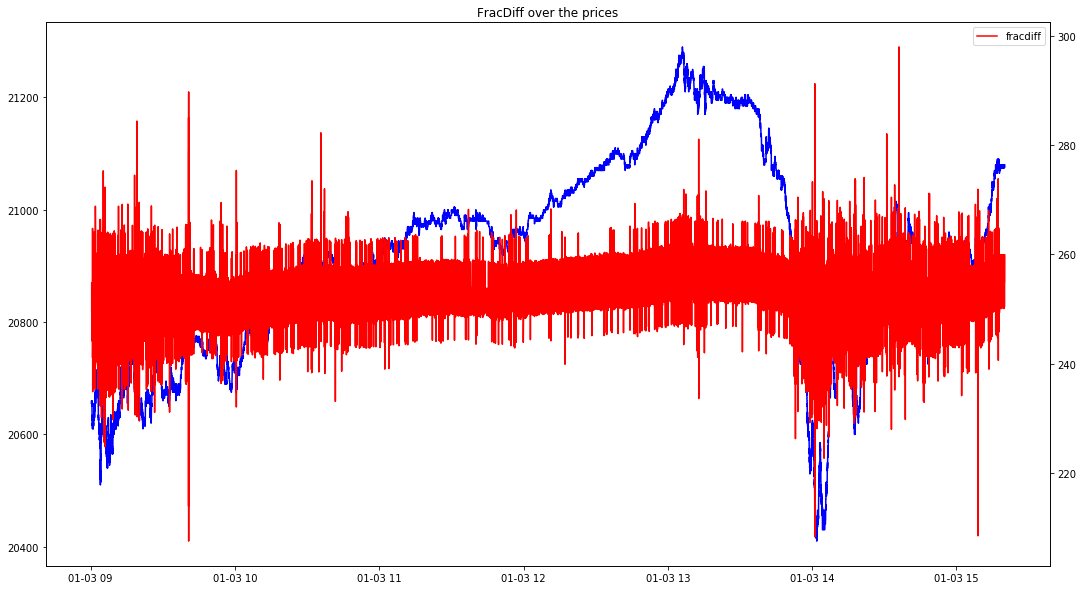

In [95]:
fd_ffd = features.frac_diff_FFD(close['close'], 0.9, thres=1e-3)
plot_fd(close, fd_ffd)

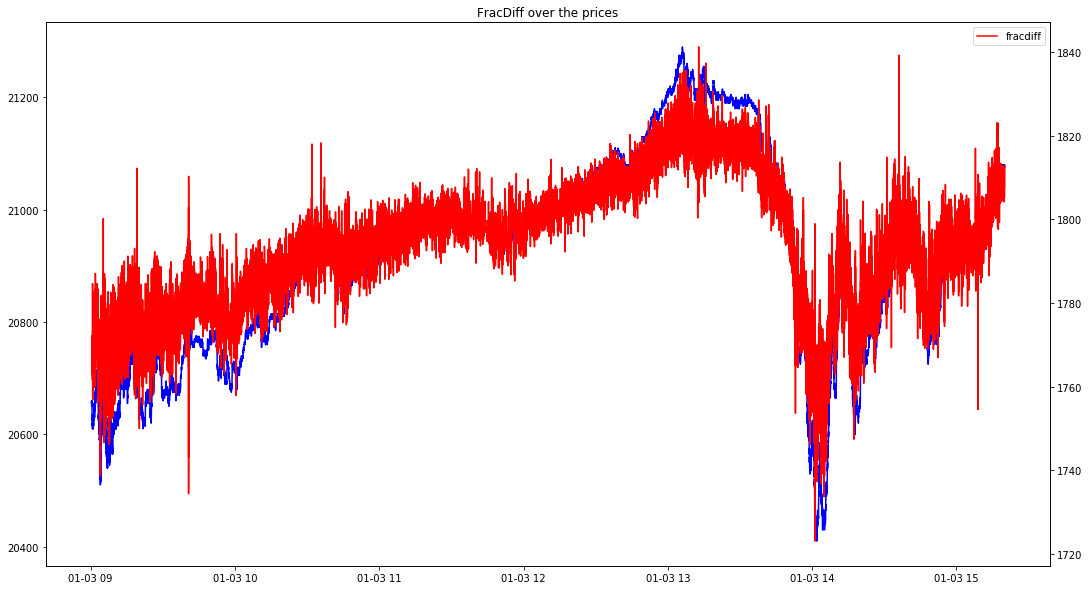

In [96]:
fd_ffd = features.frac_diff_FFD(close['close'], 0.5, thres=1e-3)
plot_fd(close, fd_ffd)

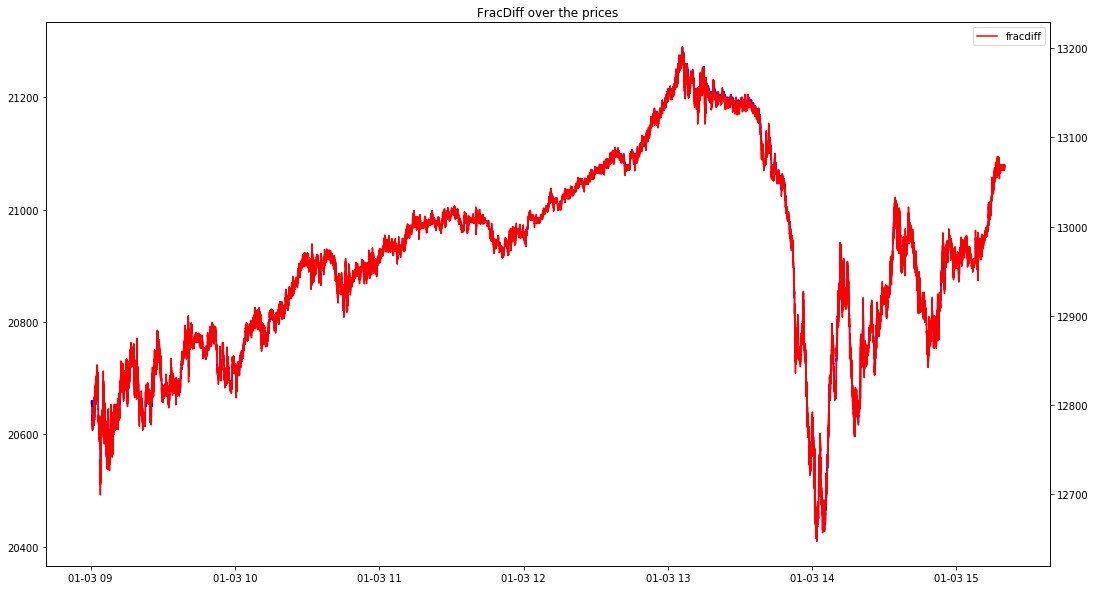

In [97]:
fd_ffd = features.frac_diff_FFD(close['close'], 0.1, thres=1e-3)
plot_fd(close, fd_ffd)

#### Determine the mininum d such that the p-value of the ADF statistic on FFD(d) falls below 5%

In [98]:
from statsmodels.tsa.stattools import adfuller

adfuller(close['close'], 12)

(-1.3194440040307938,
 0.6202303796034194,
 12,
 30680,
 {'1%': -3.430563163207825,
  '10%': -2.5668201464001963,
  '5%': -2.861634212452665},
 180035.10753465354)

In [134]:
outputs = []
ds = np.linspace(0, 1, 11)
for d in ds:
    df2 = features.frac_diff_FFD(close['close'], d, thres=1e-3)
    df2.dropna(inplace=True)
    df2 = adfuller(df2, maxlag=1, regression='c', autolag=None)
    # Pvalue
    outputs.append(df2[1])

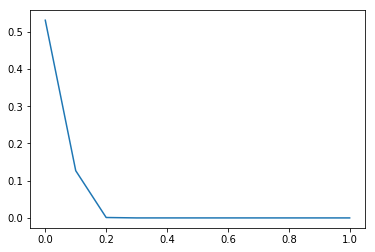

In [135]:
plt.plot(ds, outputs)

In [136]:
min_d = 0.1*(len(outputs) - (np.array(outputs)<0.05).sum())
print(min_d)

0.2


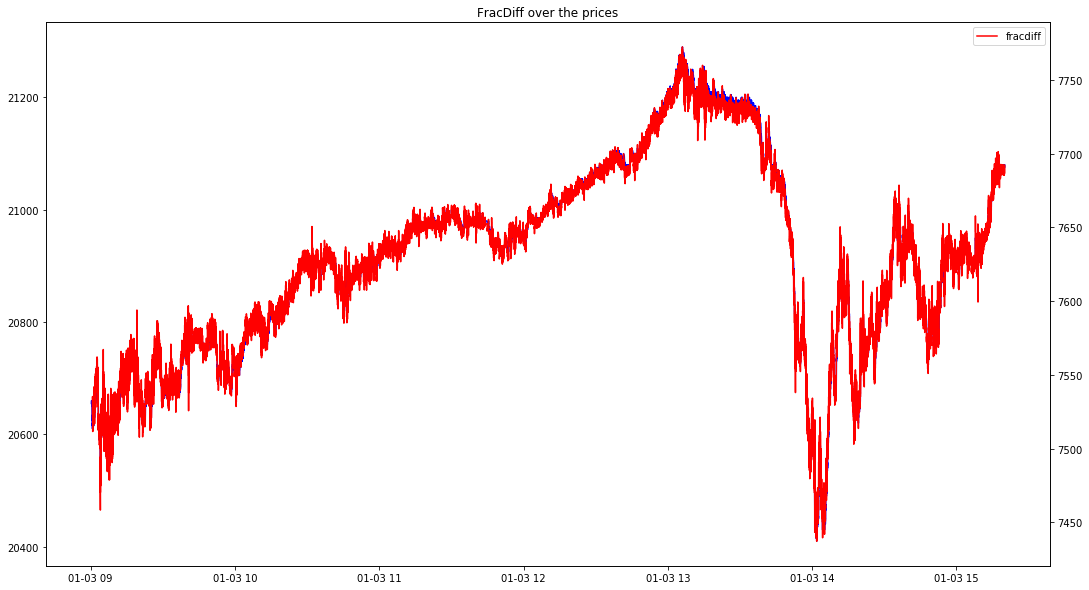

In [137]:
fd_ffd = features.frac_diff_FFD(close['close'], min_d, thres=1e-3)
plot_fd(close, fd_ffd)

In [138]:
close.shape

(30693, 1)

In [139]:
fd_ffd.shape

(30693,)